In [113]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
import akshare as ak
from datetime import datetime
import time
import os
import warnings
import seaborn as sns
# 忽略所有警告信息
warnings.filterwarnings('ignore')
plt.rcParams["font.serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [114]:
def analyzing(df):
  # print(df[["code","name","close","final_close","diff"]])
  df['date'] = pd.to_datetime(df['time'])
  df['dt'] = df['date'].dt.date
  df['hour'] = df['date'].dt.hour
  df['pct'] = round(100 * df['diff'] / df['close'], 2)
  
  dt = df.iloc[0]['date']
  df_trade = df
  
  cost = 100 * df_trade['close']
  cost = int(cost.sum())
  
  profit = 100 * df_trade['diff']
  profit = round(profit.sum(), 2)
  profit_rate = round(100 * profit / cost, 2) if len(df_trade)>0 else 0
   
  df_trade_win = df_trade[df_trade["diff"] > 0] 
  df_trade_win_count = len(df_trade_win)
  df_trade_fail_count = len(df_trade) - len(df_trade_win)
  
  win_rate = round(100 * df_trade_win_count / len(df_trade), 2) if len(df_trade)>0 else 0
  fail_rate = round(100 * df_trade_fail_count / len(df_trade), 2) if len(df_trade)>0 else 0
  
  symobl_counts = df_trade['code'].nunique()
  return {
          '时间段': f'{dt}',
          '股票个数': symobl_counts,
          '交易笔数': len(df_trade), 
          '总成本': cost, 
          '总收益': profit, 
          '做对笔数': df_trade_win_count, 
          '做错笔数': df_trade_fail_count, 
          '胜率': win_rate, 
          '败率': fail_rate, 
          '收益率':profit_rate
          }

In [115]:
data_type = {
    'time': str,
    'code': str,
    'name': str,
    'signal': str,
    'price': float,
    'final_close': float,
    'diff': float
}

print("甘州图灵交易信号分析报告")
directory = 'results/bests'
files = sorted([f for f in os.listdir(directory) if f.endswith('.csv')])
daily_results_buy= []
daily_results_sell= []
df_spot = ak.stock_zh_a_spot_em()

for filename in files:
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        # if not file_path.endswith("2024-09-27-09-30-46.csv"): continue
        df = pd.read_csv(file_path, dtype=data_type)
        if not hasattr(df, 'time'):
           df.rename(columns={"date":"time"},inplace=True)
           for ind,row in df.iterrows():
               code = row["code"]
               closing_price = df_spot.query(f'`代码` == "{code}"')['最新价'].iloc[0]
               df.loc[ind,'final_close'] = closing_price
               df.loc[ind,'diff'] = closing_price -  row["close"]               
        daily_results_buy.append(analyzing(df))
        # print(df)
        # print(df[["code" ,  "name" ,  "close", "upper_limit_x", "final_close",  "diff"]])
df_trade_results = pd.DataFrame(daily_results_buy)
df_trade_results.to_csv(f'results_for_bests.csv', index=False,encoding='utf_8_sig')


甘州图灵交易信号分析报告
      code   name  close  upper_limit_x  final_close  diff
0   601162   天风证券   3.39           3.63         3.99  0.60
1   600705   中航产融   2.98           3.18         3.36  0.38
2   000158   常山北明  12.60          13.29        11.99 -0.61
3   600643   爱建集团   5.43           5.43         5.64  0.21
4   002607   中公教育   2.27           2.43         2.50  0.23
5   000402  金 融 街   2.70           2.89         3.18  0.48
6   600318   新力金融   7.27           8.01         7.64  0.37
7   300072   海新能科   3.01           3.60         3.52  0.51
8   002717   岭南股份   2.10           2.28         2.31  0.21
9   300085    银之杰  19.36          22.78        27.34  7.98
10  002659   凯文教育   4.68           4.85         4.74  0.06
11  000676   智度股份   6.79           7.47         7.12  0.33
12  002640    跨境通   2.24           2.43         2.43  0.19
13  000906   浙商中拓   5.48           5.91         5.97  0.49
14  000567   海德股份   5.49           6.06         6.29  0.80
15  600838   上海九百   7.70           8.29    

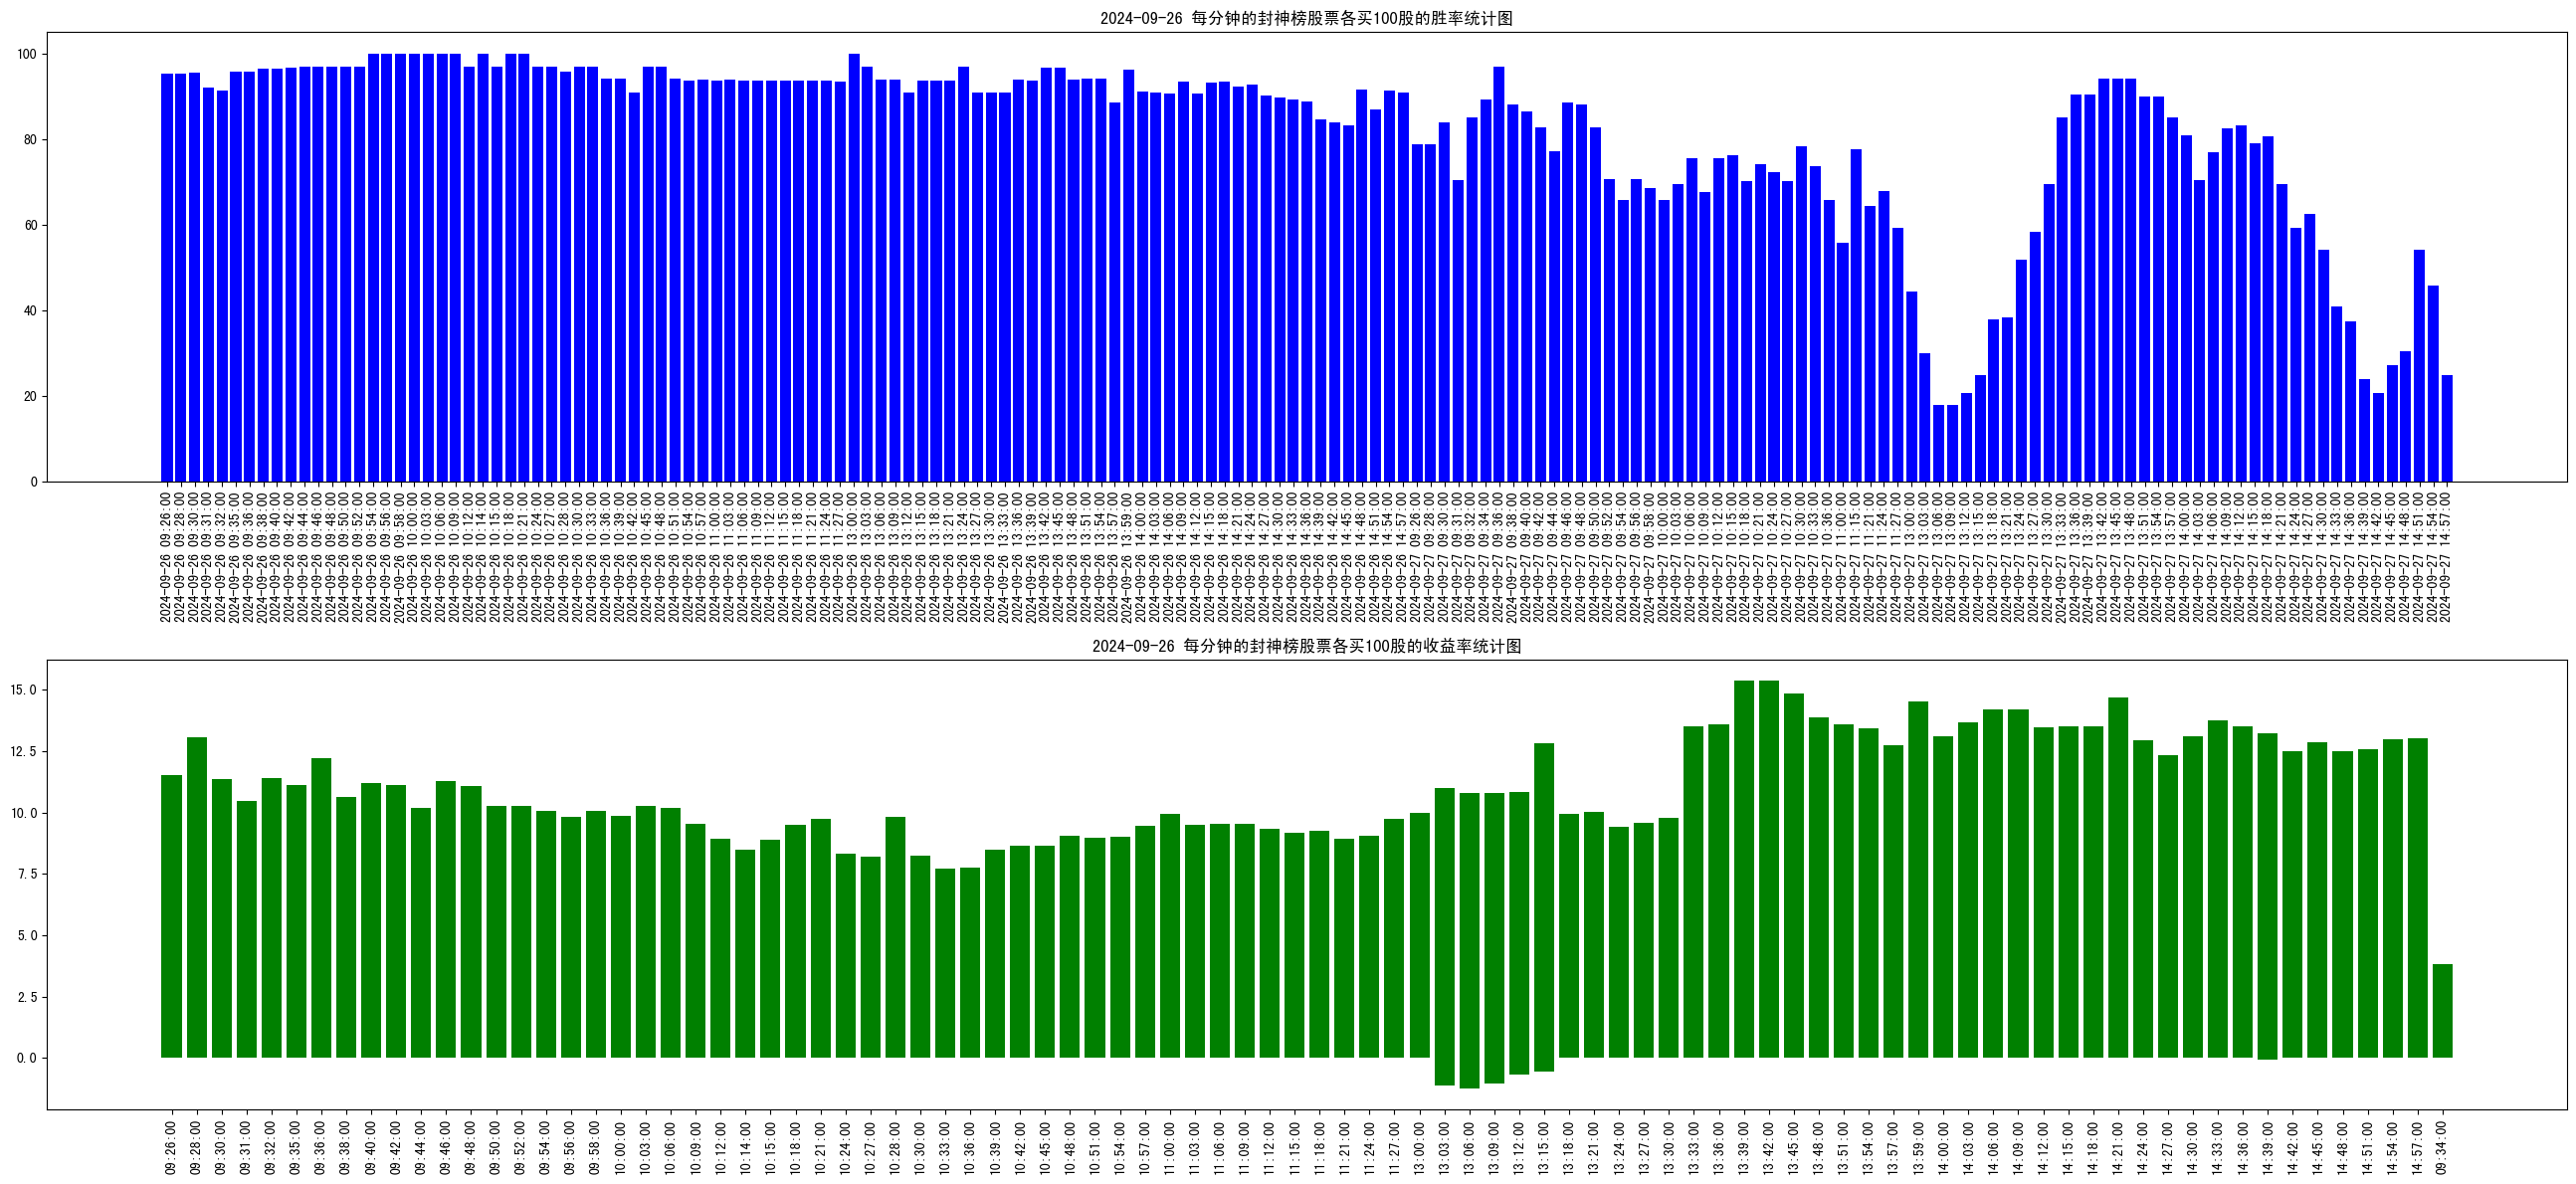

In [116]:
df_trade_results["time_segment"] = df_trade_results["时间段"].astype(str).str[11:]
# 设置图表大小
plt.figure(figsize=(26, 12))


# 绘制胜率柱状图
plt.subplot(2, 1, 1)  # 3行1列的第1个
plt.bar(df_trade_results['时间段'], df_trade_results['胜率'], color='b')
plt.title(f'2024-09-26 每分钟的封神榜股票各买100股的胜率统计图')
plt.xticks(rotation=90)  # 旋转x轴标签以便更好地显示

# 绘制收益率柱状图
plt.subplot(2, 1, 2)  # 3行1列的第3个
plt.bar(df_trade_results['time_segment'], df_trade_results['收益率'], color='g')
plt.title('2024-09-26 每分钟的封神榜股票各买100股的收益率统计图')
plt.xticks(rotation=90)

# 调整布局
plt.tight_layout()
plt.show()

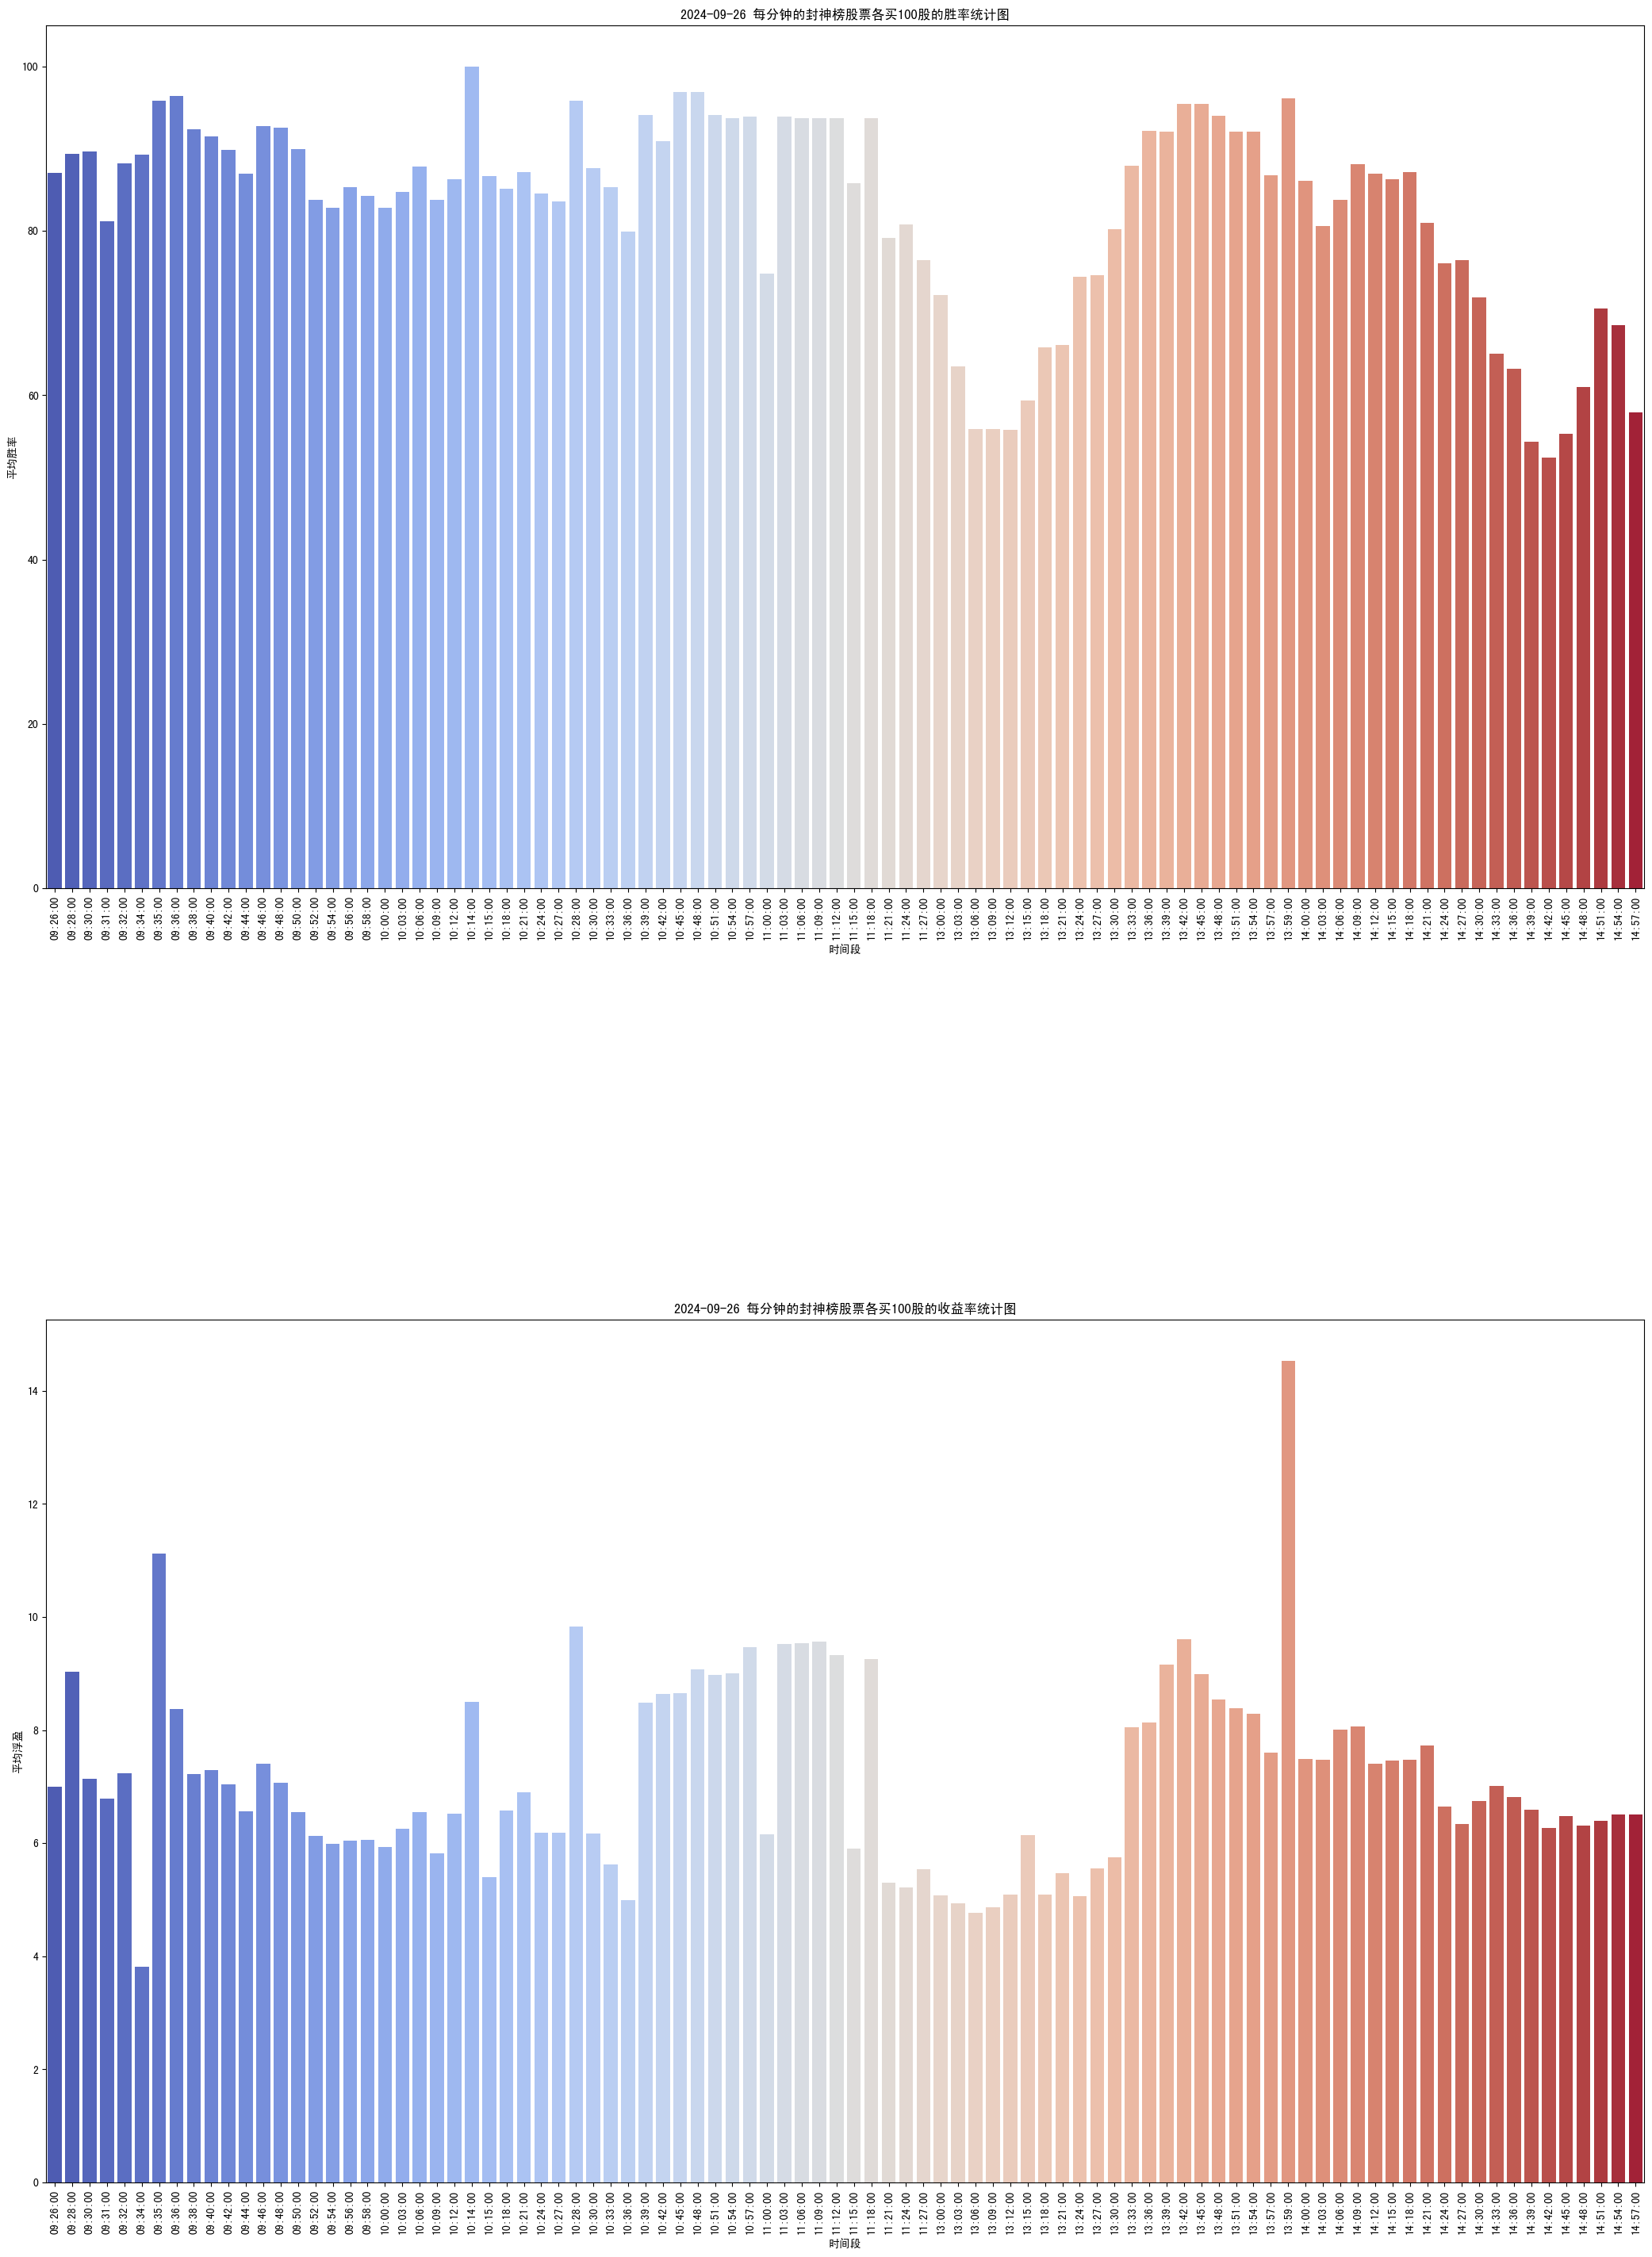

In [117]:
# 计算每个时段的平均胜率和平均收益率
avg_win_rate = df_trade_results.groupby('time_segment')['胜率'].mean()
avg_return_rate = df_trade_results.groupby('time_segment')['收益率'].mean()

start_date = df_trade_results.iloc[0]["时间段"][:10]
end_date = df_trade_results.iloc[-1]["时间段"][:10]
# 创建一个图表窗口，并设置子图的布局
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(26, 16))

# 绘制平均胜率图
win_rate_colors = sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=avg_win_rate.index, y=avg_win_rate.values, ax=ax1, palette="coolwarm")
ax1.set_title(f'2024-09-26 每分钟的封神榜股票各买100股的胜率统计图')
ax1.set_xlabel('时间段')
ax1.set_ylabel('平均胜率')


# 绘制平均收益率图
return_rate_colors = sns.color_palette("Greens", as_cmap=True)
sns.barplot(x=avg_return_rate.index, y=avg_return_rate.values, ax=ax2, palette="coolwarm")
ax2.set_title(f'2024-09-26 每分钟的封神榜股票各买100股的收益率统计图')
ax2.set_xlabel('时间段')
ax2.set_ylabel('平均浮盈')

# 旋转 X 轴标签
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# 调整子图之间的垂直间隔
fig.subplots_adjust(bottom=0.1, top=1.8, hspace=0.5)
plt.show()
